In [1]:
# -------------------- Imports --------------------
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
IMG_SIZE = 224
NUM_CLASSES = 8
BATCH_SIZE = 16
EPOCHS = 20
THRESHOLD = 0.3

In [3]:
# -------------------- Config --------------------
BASE_PATH = '/kaggle/input/odir-dataset/OIA-ODIR'  
TRAIN_IMG_PATH = os.path.join(BASE_PATH, 'Training Set/Images')
TRAIN_EXCEL_PATH = os.path.join(BASE_PATH, 'Training Set/Annotation/training annotation (English).xlsx')

ON_SITE_IMG_PATH = os.path.join(BASE_PATH, 'On-site Test Set/Images')
ON_SITE_EXCEL_PATH = os.path.join(BASE_PATH, 'On-site Test Set/Annotation/on-site test annotation (English).xlsx')

OFF_SITE_IMG_PATH = os.path.join(BASE_PATH, 'Off-site Test Set/Images')
OFF_SITE_EXCEL_PATH = os.path.join(BASE_PATH, 'Off-site Test Set/Annotation/off-site test annotation (English).xlsx')


In [4]:
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])
def preprocess_image(path, augment=False):
    img = cv2.imread(path)
    if img is None:
        return None, None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if augment:
        img = transform_aug(img)
    else:
        img = transforms.ToTensor()(img)
    return img.numpy(), img.permute(1, 2, 0).numpy()

In [5]:
class FundusDataset(Dataset):
    def __init__(self, df, image_dir, augment=False):
        self.df = df
        self.image_dir = image_dir
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        left_path = os.path.join(self.image_dir, os.path.basename(str(row['Left-Fundus'])))
        right_path = os.path.join(self.image_dir, os.path.basename(str(row['Right-Fundus'])))
        left, left_orig = preprocess_image(left_path, augment=self.augment)
        right, right_orig = preprocess_image(right_path, augment=self.augment)
        label = row[label_columns].values.astype(np.float32)
        return torch.tensor(left), torch.tensor(right), torch.tensor(label), left_orig, right_orig


In [6]:
# -------------------- Load Data --------------------
df_train = pd.read_excel(TRAIN_EXCEL_PATH).dropna().reset_index(drop=True)
train_ds = FundusDataset(df_train, TRAIN_IMG_PATH)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
df_on = pd.read_excel(ON_SITE_EXCEL_PATH).dropna().reset_index(drop=True)
df_off = pd.read_excel(OFF_SITE_EXCEL_PATH).dropna().reset_index(drop=True)

on_site_ds = FundusDataset(df_on, ON_SITE_IMG_PATH)
off_site_ds = FundusDataset(df_off, OFF_SITE_IMG_PATH)

on_site_loader = DataLoader(on_site_ds, batch_size=BATCH_SIZE)
off_site_loader = DataLoader(off_site_ds, batch_size=BATCH_SIZE)


Displaying 5 Random Fundus Images...


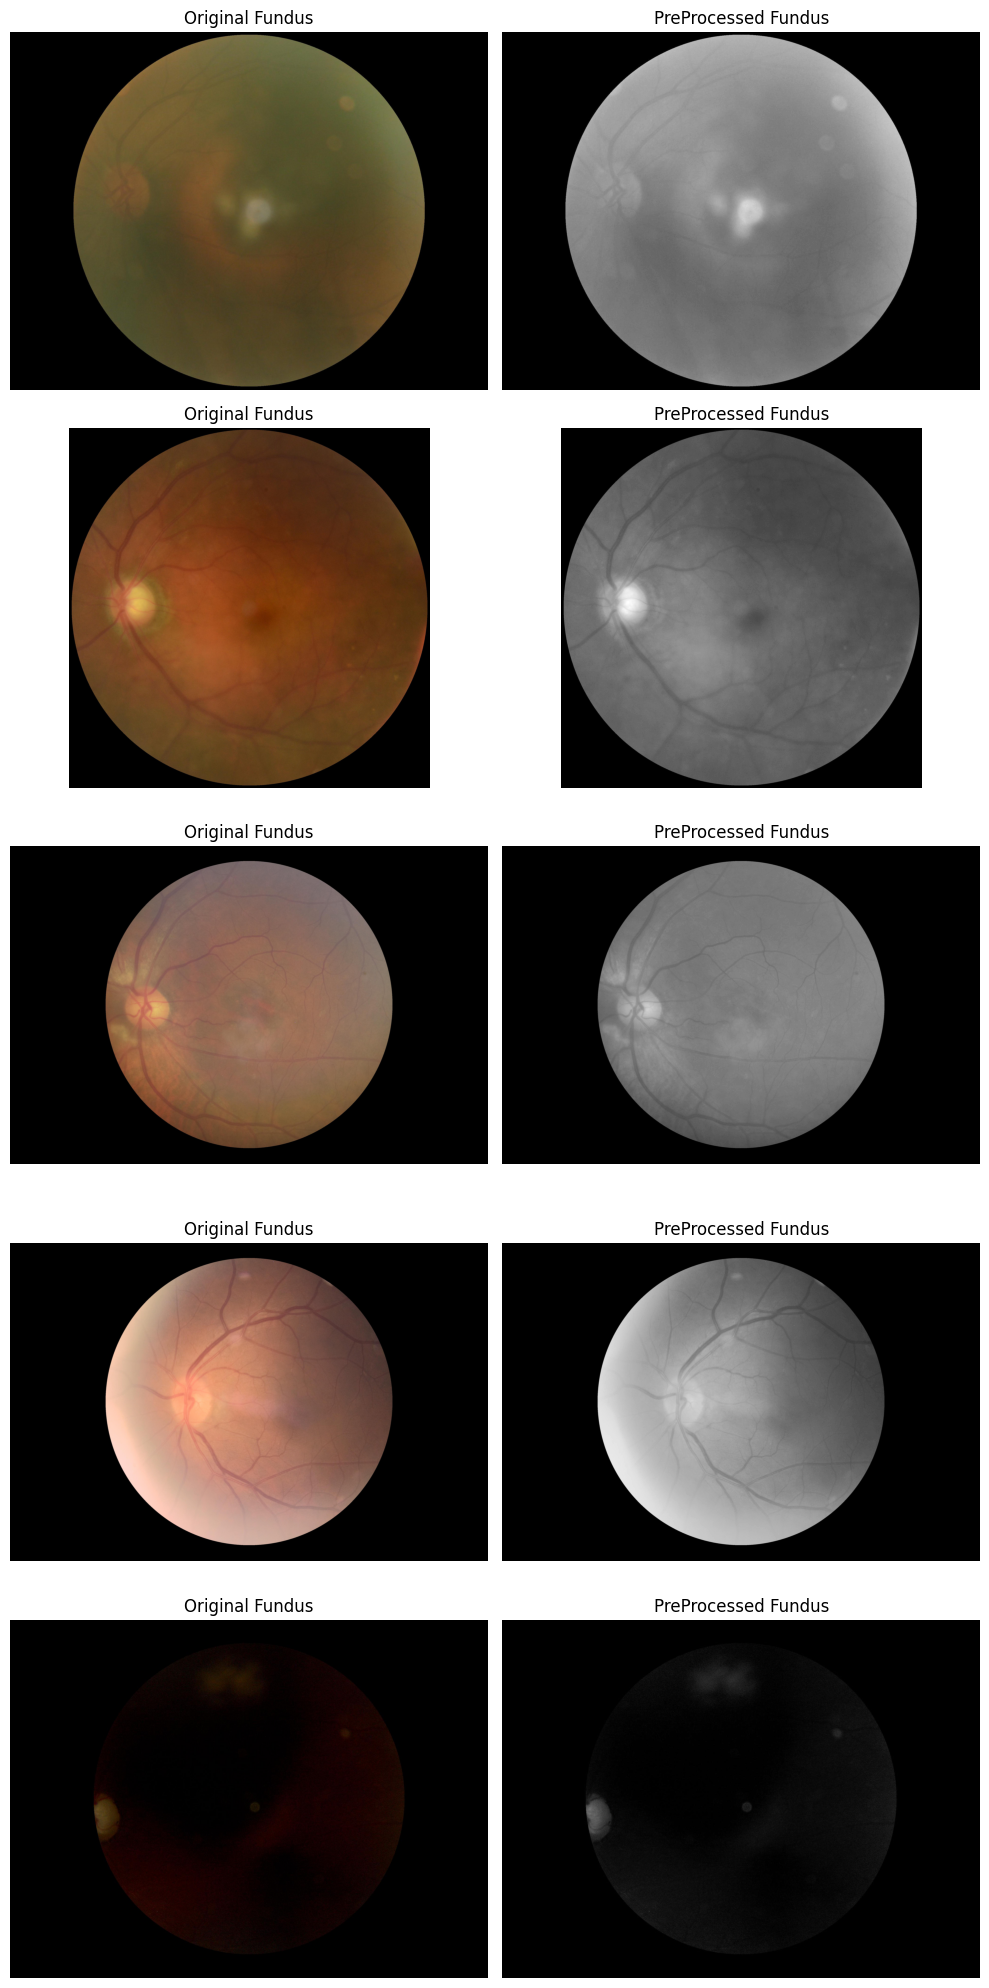

In [7]:


def sample_image_preprocessing(df, img_dir):
    print("Displaying 5 Random Fundus Images...")
    sample_df = df.sample(5)

    fig, axs = plt.subplots(5, 2, figsize=(10, 20))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(img_dir, row['Left-Fundus'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable image: {img_path}")
            continue

        # Convert to RGB and Grayscale
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Show RGB
        axs[i, 0].imshow(rgb_img)
        axs[i, 0].set_title("Original Fundus")
        axs[i, 0].axis('off')

        # Show Grayscale
        axs[i, 1].imshow(gray_img, cmap='gray')
        axs[i, 1].set_title("PreProcessed Fundus")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
sample_image_preprocessing(df_train, TRAIN_IMG_PATH)


In [8]:
# -------------------- Model Blocks --------------------
class ConvBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pconv = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.dsconv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, groups=channels),
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

    def forward(self, x):
        return torch.cat([self.dsconv(x), self.pconv(x)], dim=1)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

class DRBMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

class FundusDeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ConvBackbone()
        self.attn = AttentionBlock(256)
        self.se = SEBlock(512)
        self.drbm = DRBMClassifier(512, 128, NUM_CLASSES)

    def forward(self, left, right):
        fl = self.backbone(left)
        fr = self.backbone(right)
        pl = self.attn(fl)
        pr = self.attn(fr)
        fused = self.se(pl * pr)
        gap = F.adaptive_avg_pool2d(fused, (1, 1)).view(fused.size(0), -1)
        return self.drbm(gap)

# -------------------- Weight Initialization --------------------
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# -------------------- Create and Initialize Model --------------------
model = FundusDeepNet()
model.apply(init_weights)


FundusDeepNet(
  (backbone): ConvBackbone(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Co

In [9]:
# -------------------- Load OIA-ODIR Data --------------------
df_train = pd.read_excel(TRAIN_EXCEL_PATH).dropna().reset_index(drop=True)
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'] 
def oversample_df(df, label_columns):
    max_count = int(df[label_columns].sum().max())
    oversampled = []
    for label in label_columns:
        samples = df[df[label] == 1]
        if len(samples) == 0: continue
        repeat_factor = max_count // len(samples)
        oversampled.append(pd.concat([samples] * repeat_factor, ignore_index=True))
    balanced_df = pd.concat(oversampled + [df], ignore_index=True)
    return balanced_df.sample(frac=1).reset_index(drop=True)

df_train_balanced = oversample_df(df_train, label_columns)
train_ds = FundusDataset(df_train_balanced, TRAIN_IMG_PATH, augment=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

df_on = pd.read_excel(ON_SITE_EXCEL_PATH).dropna().reset_index(drop=True)
on_site_ds = FundusDataset(df_on, ON_SITE_IMG_PATH)
on_site_loader = DataLoader(on_site_ds, batch_size=BATCH_SIZE)

df_off = pd.read_excel(OFF_SITE_EXCEL_PATH).dropna().reset_index(drop=True)
off_site_ds = FundusDataset(df_off, OFF_SITE_IMG_PATH)
off_site_loader = DataLoader(off_site_ds, batch_size=BATCH_SIZE)


In [10]:
# -------------------- Train --------------------
def calculate_accuracy(y_true, logits):
    preds = torch.sigmoid(logits) > THRESHOLD
    return (preds == y_true).float().sum() / y_true.numel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FundusDeepNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']  # make sure this matches your actual labels

label_freq = df_train[label_columns].sum()
class_weights = 1.0 / (label_freq + 1e-6)
class_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)


def evaluate(model, loader, name="Validation"):
    model.eval()
    total_loss = 0
    total_acc = 0
    batches = 0

    with torch.no_grad():
        for xl, xr, y, _, _ in loader:
            xl, xr, y = xl.to(device), xr.to(device), y.to(device)
            logits = model(xl, xr)
            loss = criterion(logits, y)
            acc = calculate_accuracy(y, logits)
            total_loss += loss.item()
            total_acc += acc.item()
            batches += 1

    avg_loss = total_loss / batches
    avg_acc = total_acc / batches
    return avg_loss, avg_acc

for epoch in range(1, EPOCHS + 1):
    # -------- Training --------
    model.train()
    total_loss = 0
    total_acc = 0
    batches = 0

    for xl, xr, y, _, _ in train_loader:
        xl, xr, y = xl.to(device), xr.to(device), y.to(device)
        logits = model(xl, xr)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(y, logits)
        total_loss += loss.item()
        total_acc += acc.item()
        batches += 1

    avg_train_loss = total_loss / batches
    avg_train_acc = total_acc / batches

    # -------- Validation on On-site and Off-site --------
    avg_on_loss, avg_on_acc = evaluate(model, on_site_loader, name="On-site")
    avg_off_loss, avg_off_acc = evaluate(model, off_site_loader, name="Off-site")

    scheduler.step()

    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} || "
          f"On-site Val Loss: {avg_on_loss:.4f} | On-site Val Acc: {avg_on_acc:.4f} || "
          f"Off-site Val Loss: {avg_off_loss:.4f} | Off-site Val Acc: {avg_off_acc:.4f}")


Epoch 01 | Train Loss: 0.1284 | Train Acc: 0.7797 || On-site Val Loss: 0.0510 | On-site Val Acc: 0.8533 || Off-site Val Loss: 0.0507 | Off-site Val Acc: 0.8535
Epoch 02 | Train Loss: 0.0848 | Train Acc: 0.8336 || On-site Val Loss: 0.0506 | On-site Val Acc: 0.8524 || Off-site Val Loss: 0.0508 | Off-site Val Acc: 0.8530
Epoch 03 | Train Loss: 0.0791 | Train Acc: 0.8351 || On-site Val Loss: 0.0510 | On-site Val Acc: 0.8518 || Off-site Val Loss: 0.0496 | Off-site Val Acc: 0.8547
Epoch 04 | Train Loss: 0.0728 | Train Acc: 0.8396 || On-site Val Loss: 0.0487 | On-site Val Acc: 0.8535 || Off-site Val Loss: 0.0459 | Off-site Val Acc: 0.8582
Epoch 05 | Train Loss: 0.0694 | Train Acc: 0.8428 || On-site Val Loss: 0.0457 | On-site Val Acc: 0.8562 || Off-site Val Loss: 0.0443 | Off-site Val Acc: 0.8584
Epoch 06 | Train Loss: 0.0658 | Train Acc: 0.8467 || On-site Val Loss: 0.0526 | On-site Val Acc: 0.8531 || Off-site Val Loss: 0.0471 | Off-site Val Acc: 0.8591
Epoch 07 | Train Loss: 0.0645 | Train Ac

In [11]:
torch.save(model, 'fundus_deepnet_full.pt')

In [12]:
from sklearn.metrics import roc_auc_score, classification_report, cohen_kappa_score
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_model(model, loader, title="Dataset"):
    y_true_all = []
    y_prob_all = []

    model.eval()
    with torch.no_grad():
        for xl, xr, y, _, _ in loader:
            xl, xr = xl.to(device), xr.to(device)
            logits = model(xl, xr)
            probs = torch.sigmoid(logits).cpu().numpy()
            y_true_all.append(y.numpy())
            y_prob_all.append(probs)

    y_true_all = np.vstack(y_true_all)
    y_prob_all = np.vstack(y_prob_all)
    y_pred_all = (y_prob_all > THRESHOLD).astype(int)

    acc = (y_true_all == y_pred_all).sum() / y_true_all.size

    report = classification_report(
        y_true_all, y_pred_all, output_dict=True, zero_division=0
    )
    macro = report["macro avg"]

    print(f"\nResults for {title}")
    print(f"Final Accuracy     : {acc:.4f}")
    print(f"Precision    : {macro['precision']:.4f}")
    print(f"Recall       : {macro['recall']:.4f}")
    print(f"F1-score     : {macro['f1-score']:.4f}")
    print(f"AUC      : {roc_auc_score(y_true_all, y_prob_all, average='macro'):.4f}")
    print(f"Cohen’s Kappa      : {cohen_kappa_score(y_true_all.flatten(), y_pred_all.flatten()):.4f}")

    return y_true_all, y_prob_all, y_pred_all


In [21]:
# Evaluate both splits
y_true_onsite, y_prob_onsite, y_pred_onsite = evaluate_model(model, on_site_loader, title="Onsite Test")
y_true_offsite, y_prob_offsite, y_pred_offsite = evaluate_model(model, off_site_loader, title="Offsite Test")

Results for Onsite Test
Final Accuracy     : 0.8538
Precision          : 0.8600
Recall             : 0.9880
F1-score           : 0.9190
AUC                : 0.7579
Cohen’s Kappa      : 0.7357

Results for Offsite Test
Final Accuracy     : 0.8592
Precision          : 0.8610
Recall             : 0.9910
F1-score           : 0.9204
AUC                : 0.7581
Cohen’s Kappa      : 0.5778


In [14]:
from sklearn.metrics import multilabel_confusion_matrix,roc_curve, auc
def plot_confusion_matrix_global(y_true, y_pred, title=""):
    cm = multilabel_confusion_matrix(y_true, y_pred).sum(axis=0)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for (j, k), val in np.ndenumerate(cm):
        plt.text(k, j, f'{val}', ha='center', va='center', color='red')
    plt.tight_layout()
    plt.show()


def plot_roc_macro(y_true, y_prob, title=""):
    n_classes = y_true.shape[1]
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, alpha=0.6, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'AUC-ROC Curve - {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


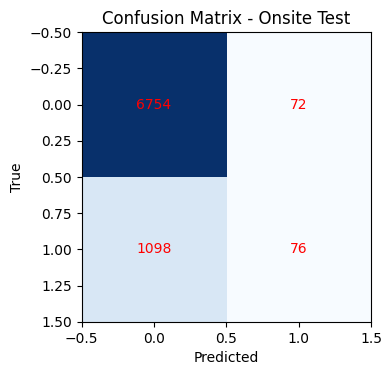

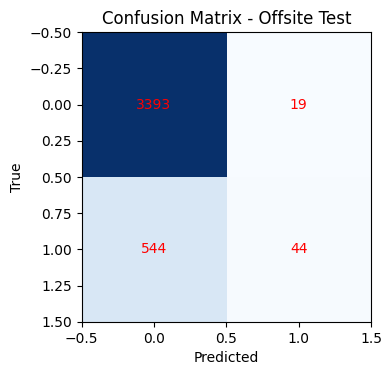

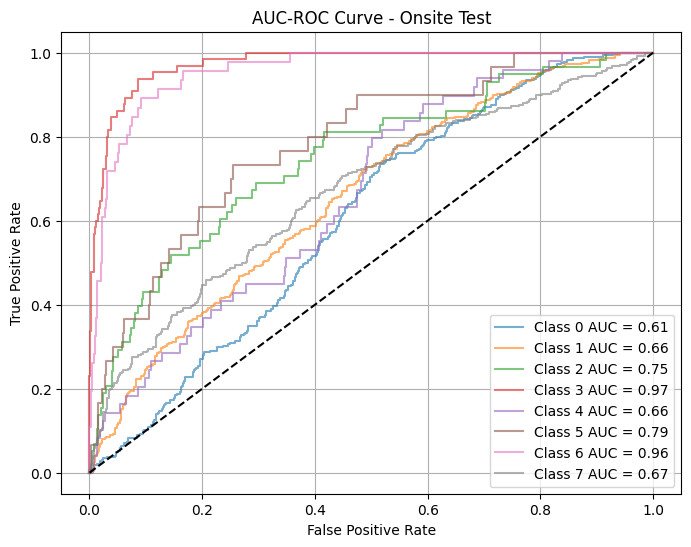

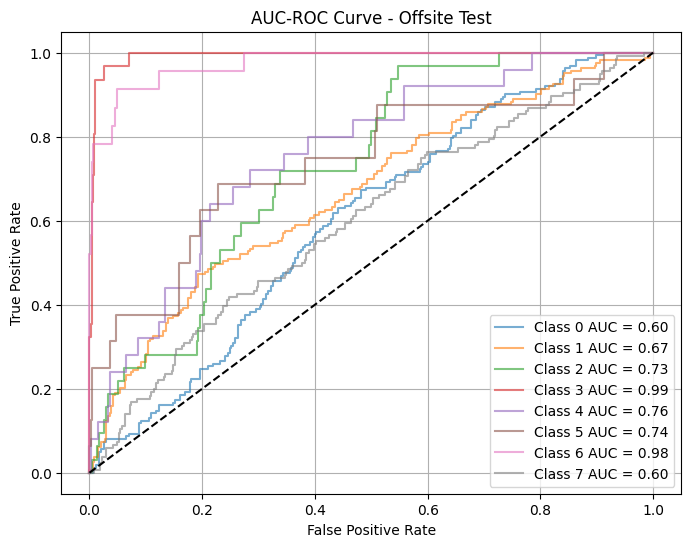

In [15]:

# Plot metrics
plot_confusion_matrix_global(y_true_onsite, y_pred_onsite, title="Onsite Test")
plot_confusion_matrix_global(y_true_offsite, y_pred_offsite, title="Offsite Test")

plot_roc_macro(y_true_onsite, y_prob_onsite, title="Onsite Test")
plot_roc_macro(y_true_offsite, y_prob_offsite, title="Offsite Test")


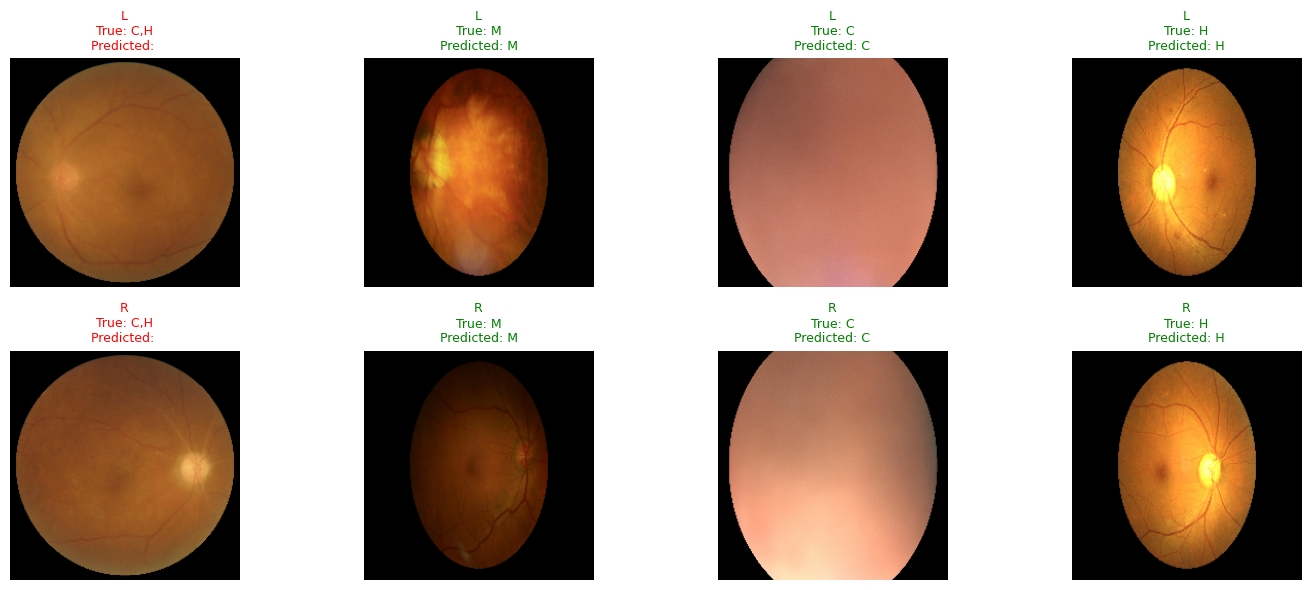

In [16]:
THRESHOLD = 0.3
label_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

def decode_labels(label_vec):
    return [label_names[i] for i, val in enumerate(label_vec) if val == 1]

def decode_preds(pred_vec):
    return [label_names[i] for i, val in enumerate(pred_vec) if val == 1]

to_pil = transforms.ToPILImage()
samples = []
correct_labels = set()
incorrect_added = False

for i in range(len(on_site_ds)):
    xl, xr, y, _, _ = on_site_ds[i]

    xl_tensor = xl.unsqueeze(0).to(device)
    xr_tensor = xr.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(xl_tensor, xr_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        pred = (probs > THRESHOLD).astype(int)

    true_label = y.numpy().astype(int)
    pred_label_set = tuple(pred)

    true_names = tuple(decode_labels(true_label))

    if np.array_equal(true_label, pred):
        if true_names not in correct_labels:
            samples.append((xl, xr, true_label, pred, True))
            correct_labels.add(true_names)
    elif not incorrect_added:
        samples.append((xl, xr, true_label, pred, False))
        incorrect_added = True

    if len(samples) == 5:
        break

if samples:
    plt.figure(figsize=(18, 6))
    for idx, (xl, xr, true_label, pred, is_correct) in enumerate(samples):
        true_str = ','.join(decode_labels(true_label))
        pred_str = ','.join(decode_preds(pred))
        color = 'green' if is_correct else 'red'

        left_img = to_pil(xl.cpu())
        right_img = to_pil(xr.cpu())

        plt.subplot(2, 5, idx + 1)
        plt.imshow(left_img)
        plt.axis('off')
        plt.title(f"L\nTrue: {true_str}\nPredicted: {pred_str}", fontsize=9, color=color)

        plt.subplot(2, 5, idx + 6)
        plt.imshow(right_img)
        plt.axis('off')
        plt.title(f"R\nTrue: {true_str}\nPredicted: {pred_str}", fontsize=9, color=color)

    plt.tight_layout()
    plt.show()


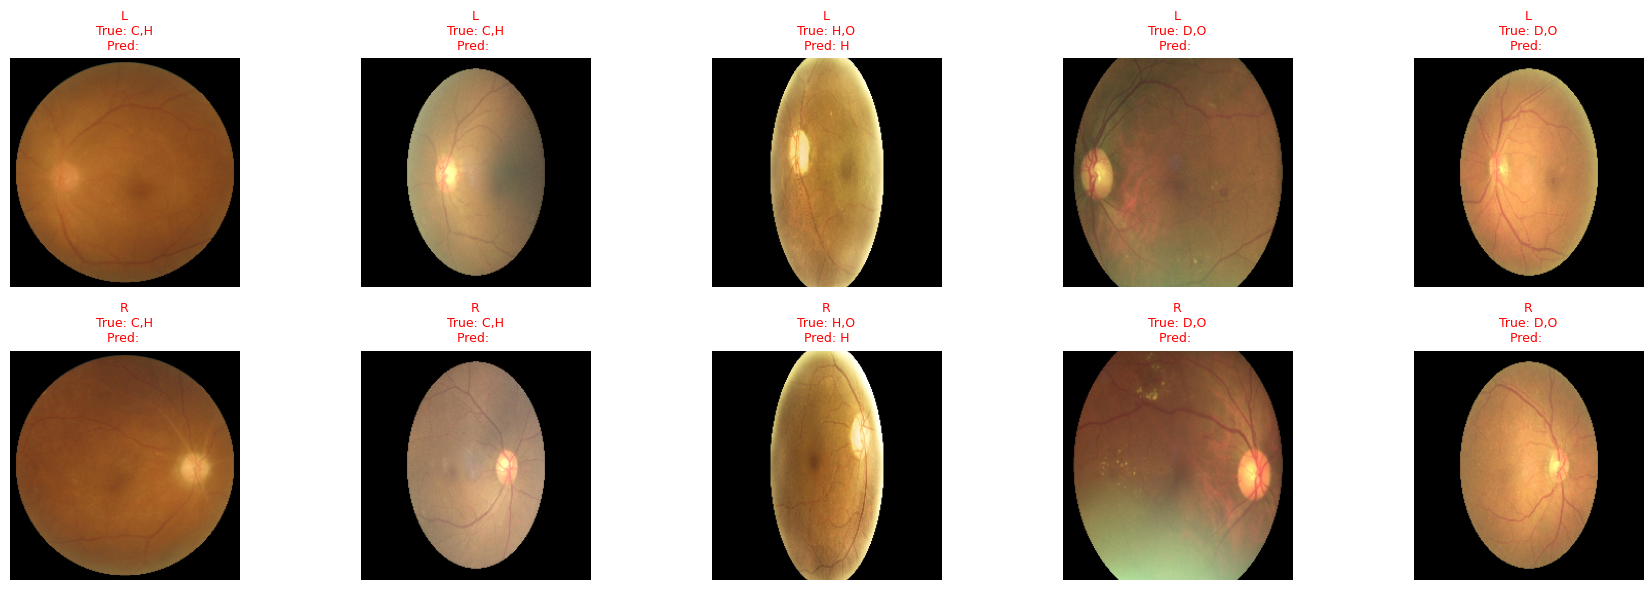

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Set a different threshold
THRESHOLD = 0.5

label_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

def decode_labels(label_vec):
    return [label_names[i] for i, val in enumerate(label_vec) if val == 1]

def decode_preds(pred_vec):
    return [label_names[i] for i, val in enumerate(pred_vec) if val == 1]

to_pil = transforms.ToPILImage()
wrong_samples = []

# Loop through dataset and collect only incorrect predictions
for i in range(len(on_site_ds)):
    xl, xr, y, _, _ = on_site_ds[i]

    xl_tensor = xl.unsqueeze(0).to(device)
    xr_tensor = xr.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(xl_tensor, xr_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        pred = (probs > THRESHOLD).astype(int)

    true_label = y.numpy().astype(int)

    if not np.array_equal(true_label, pred):  # Only keep incorrect
        wrong_samples.append((xl, xr, true_label, pred))
    
    if len(wrong_samples) == 5:
        break

# Plotting incorrect predictions
if wrong_samples:
    plt.figure(figsize=(18, 6))
    for idx, (xl, xr, true_label, pred) in enumerate(wrong_samples):
        true_str = ','.join(decode_labels(true_label))
        pred_str = ','.join(decode_preds(pred))

        left_img = to_pil(xl.cpu())
        right_img = to_pil(xr.cpu())

        # Top row: left image
        plt.subplot(2, 5, idx + 1)
        plt.imshow(left_img)
        plt.axis('off')
        plt.title(f"L\nTrue: {true_str}\nPred: {pred_str}", fontsize=9, color='red')

        # Bottom row: right image
        plt.subplot(2, 5, idx + 6)
        plt.imshow(right_img)
        plt.axis('off')
        plt.title(f"R\nTrue: {true_str}\nPred: {pred_str}", fontsize=9, color='red')

    plt.tight_layout()
    plt.show()


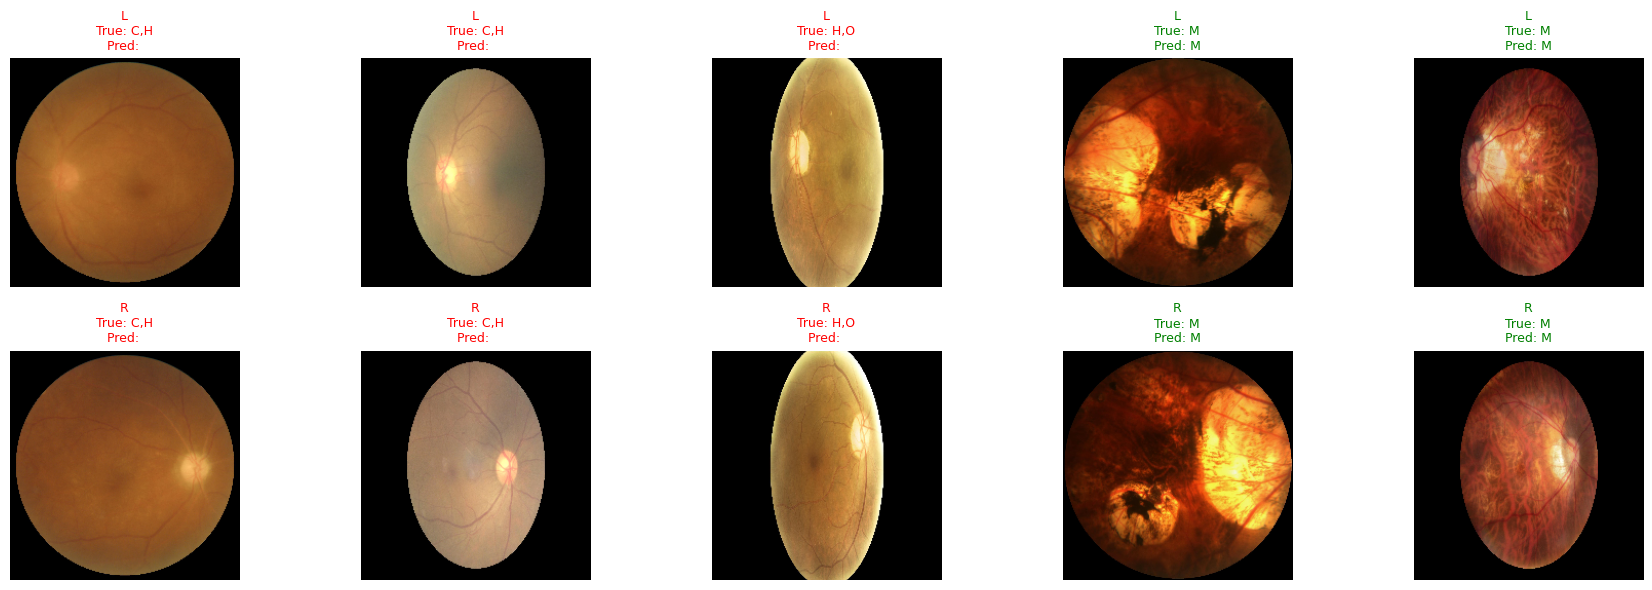

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Set a custom threshold
THRESHOLD = 0.8

label_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

def decode_labels(label_vec):
    return [label_names[i] for i, val in enumerate(label_vec) if val == 1]

def decode_preds(pred_vec):
    return [label_names[i] for i, val in enumerate(pred_vec) if val == 1]

to_pil = transforms.ToPILImage()
samples = []
correct_count = 0
incorrect_count = 0
max_correct = 2
max_incorrect = 3

# Loop through dataset
for i in range(len(on_site_ds)):
    xl, xr, y, _, _ = on_site_ds[i]

    xl_tensor = xl.unsqueeze(0).to(device)
    xr_tensor = xr.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(xl_tensor, xr_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        pred = (probs > THRESHOLD).astype(int)

    true_label = y.numpy().astype(int)

    is_correct = np.array_equal(true_label, pred)

    if is_correct and correct_count < max_correct:
        samples.append((xl, xr, true_label, pred, True))
        correct_count += 1
    elif not is_correct and incorrect_count < max_incorrect:
        samples.append((xl, xr, true_label, pred, False))
        incorrect_count += 1

    if correct_count == max_correct and incorrect_count == max_incorrect:
        break

# Plotting 5 samples: 2 correct (green), 3 incorrect (red)
if samples:
    plt.figure(figsize=(18, 6))
    for idx, (xl, xr, true_label, pred, is_correct) in enumerate(samples):
        true_str = ','.join(decode_labels(true_label))
        pred_str = ','.join(decode_preds(pred))
        color = 'green' if is_correct else 'red'

        left_img = to_pil(xl.cpu())
        right_img = to_pil(xr.cpu())

        # Top row: left image
        plt.subplot(2, 5, idx + 1)
        plt.imshow(left_img)
        plt.axis('off')
        plt.title(f"L\nTrue: {true_str}\nPred: {pred_str}", fontsize=9, color=color)

        # Bottom row: right image
        plt.subplot(2, 5, idx + 6)
        plt.imshow(right_img)
        plt.axis('off')
        plt.title(f"R\nTrue: {true_str}\nPred: {pred_str}", fontsize=9, color=color)

    plt.tight_layout()
    plt.show()
